# Simple PINN for an elastic plate with a hole 

## Represent geometry

We represent the geometry by a set of collocation points 

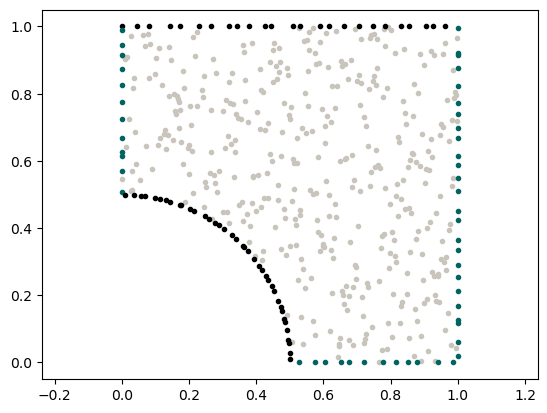

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from global_constants import EPS0, LBD, MU, L, R
from scipy.stats import qmc
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Edge samples
N = 25
# Number of collocation points
M = 500


def sample_domain():
    # Create collocation points
    points = qmc.LatinHypercube(d=2).random(M)
    mask = (points[:, 0] ** 2 + points[:, 1] ** 2) > R**2
    collocation = torch.tensor(points[mask], dtype=torch.float32)

    # Top boundary
    x_top = L * torch.tensor(qmc.LatinHypercube(d=1).random(N), dtype=torch.float32)
    y_top = L * torch.ones((N, 1), dtype=torch.float32)
    top = torch.column_stack([x_top, y_top])

    # Right boundary
    x_right = L * torch.ones((N, 1), dtype=torch.float32)
    y_right = L * torch.tensor(qmc.LatinHypercube(d=1).random(N), dtype=torch.float32)
    right = torch.column_stack([x_right, y_right])

    # Bottom boundary
    NN = int(N * (L - R) / L)
    rand_samp = qmc.LatinHypercube(d=1).random(NN)
    x_bottom = R + (L - R) * torch.tensor(rand_samp, dtype=torch.float32)
    y_bottom = torch.zeros((NN, 1), dtype=torch.float32)
    bottom = torch.column_stack([x_bottom, y_bottom])

    # Left boundary
    NN = int(N * (L - R) / L)
    rand_samp = qmc.LatinHypercube(d=1).random(NN)
    x_left = torch.zeros((NN, 1), dtype=torch.float32)
    y_left = R + (L - R) * torch.tensor(rand_samp, dtype=torch.float32)
    left = torch.column_stack([x_left, y_left])

    # Hole boundary
    rand_samp = qmc.LatinHypercube(d=1).random(int(N * np.pi * R / L)).ravel()
    phi = 0.5 * np.pi * torch.tensor(rand_samp, dtype=torch.float32)
    x_hole = R * torch.cos(phi)
    y_hole = R * torch.sin(phi)
    n_hole = torch.stack([-R * torch.cos(phi), -R * torch.sin(phi)]).T
    n_hole = n_hole / torch.linalg.norm(n_hole, axis=1)[:, None]
    hole = torch.column_stack([x_hole, y_hole])

    return collocation, top, bottom, left, right, hole, n_hole


collocation, top, bottom, left, right, hole, n_hole = sample_domain()

# Visualize geometry
with torch.no_grad():
    plt.scatter(*collocation.T, marker=".", color="#C9C5BC")
    plt.scatter(*top.T, marker=".", color="black")
    plt.scatter(*bottom.T, marker=".", color="#006561")
    plt.scatter(*left.T, marker=".", color="#006561")
    plt.scatter(*right.T, marker=".", color="#006561")
    plt.scatter(*hole.T, marker=".", color="black")
    plt.axis("equal")
    plt.show()

## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximation. In this case, it should approximate the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with four hidden layers having 40 neurons each.

We use Random Fourier Feature Embeddings for the inputs $x \in \mathcal{R}^2$, i.e., we map the input to a higher dimensional space using 
$$
\gamma(x) = \begin{bmatrix}
           \sin(2 \pi x B)\\
           \cos(2 \pi x B)
         \end{bmatrix}
$$
with $B \in \mathcal{R}^{2\times40}$ sampled from a normal distribution with mean 0 and variance $\sigma=1.0$.

In [2]:
# Number of hidden neurons
HN = 40
# Number of hidden layers
LAYERS = 4
# Variance in random Fourier feature sampling
SIGMA = 1.0
# Fourier features
FEATURES = 40


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input layer
        self.layers = torch.nn.ModuleList([torch.nn.Linear(2 * FEATURES, HN)])
        # Hidden layers
        for _ in range(LAYERS - 1):
            self.layers.append(torch.nn.Linear(HN, HN))
        # Output layer
        self.output_layer = torch.nn.Linear(HN, 2)

        # Sample B from normal distribution
        self.B = torch.normal(0.0, SIGMA, size=(2, FEATURES))

    def forward(self, x):
        # Random Fourier feature embedding
        x = torch.cat(
            [torch.sin(2 * np.pi * x @ self.B), torch.cos(2 * np.pi * x @ self.B)],
            dim=-1,
        )
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)


net = Net()

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [3]:
def sigma(x):
    dudx = torch.func.jacrev(net)(x)
    eps = 0.5 * (dudx + dudx.T)
    return 2.0 * MU * eps + LBD * torch.trace(eps) * torch.eye(2)


def pde_residual(x):
    dsdx = torch.func.jacrev(sigma)(x)
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1]
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## The loss function

In [4]:
mse = torch.nn.MSELoss()


def compute_loss(collocation, top, bottom, left, right, hole, n_hole):
    # pde
    all_points = torch.cat([collocation, top, bottom, left, right, hole])
    res_x, res_y = torch.vmap(pde_residual)(all_points)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    stress_left = torch.vmap(sigma)(left)
    zeros = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], zeros)
    left_symm_error = mse(stress_left[:, 0, 1], zeros)

    # right boundary
    pred_right = net(right)
    stress_right = torch.vmap(sigma)(right)
    zeros = torch.zeros_like(pred_right[:, 0])
    bc_right = EPS0 * L * torch.ones_like(pred_right[:, 0])
    right_error = mse(pred_right[:, 0], bc_right)
    right_symm_error = mse(stress_right[:, 0, 1], zeros)

    # bottom boundary
    pred_bottom = net(bottom)
    stress_bottom = torch.vmap(sigma)(bottom)
    zeros = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], zeros)
    bottom_symm_error = mse(stress_bottom[:, 0, 1], zeros)

    # top boundary
    stress_top = torch.vmap(sigma)(top)
    zeros = torch.zeros_like(stress_top[:, 1, 1])
    top_error = mse(stress_top[:, 1, 1], zeros) + mse(stress_top[:, 0, 1], zeros)

    # hole boundary
    stress_hole = torch.vmap(sigma)(hole)
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)

    return (
        left_error,
        left_symm_error,
        right_error,
        right_symm_error,
        bottom_error,
        bottom_symm_error,
        top_error,
        hole_error,
        pde_error,
    )

## Helper functions for weight balancing

See https://doi.org/10.48550/arXiv.2308.08468

In [5]:
# Initial weight of PDE loss
W_PDE = 1.0
# Initial weight of Dirichlet loss
W_DIR = 1.0
# Initial weight of Neumann loss
W_NEU = 1.0
# Initial weight of hole loss
W_HOLE = 1.0
# Weight update factor
ALPHA = 0.9


def compute_gradient_norm(loss):
    grads = torch.autograd.grad(loss, net.parameters(), allow_unused=True)
    return sum(0 if grad is None else torch.linalg.norm(grad) for grad in grads)


def update_weight(weight, grad_sum, norm):
    new_weight = grad_sum / norm
    return ALPHA * weight + (1 - ALPHA) * new_weight

## Training

100%|██████████| 25000/25000 [1:12:29<00:00,  5.75it/s]    


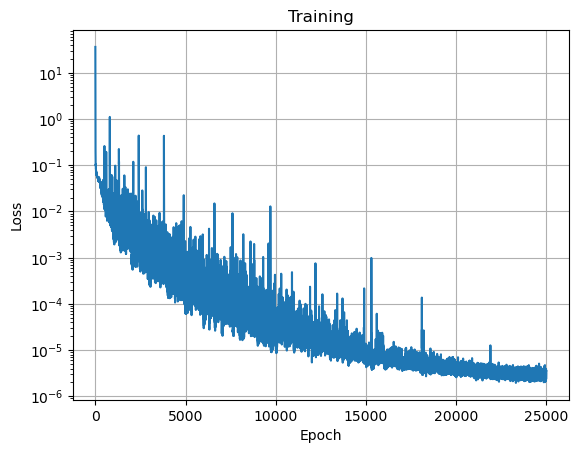

In [6]:
history = []

optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)


for epoch in tqdm(range(25000)):
    # Sample domain randomly
    collocation, top, bottom, left, right, hole, n_hole = sample_domain()

    # Train batches of 100 collocation points
    for collo in torch.chunk(collocation, int(M / 100)):
        optimizer.zero_grad()

        # Compute physics losses
        (
            left_l,
            left_sl,
            right_l,
            right_sl,
            bottom_l,
            bottom_sl,
            top_l,
            hole_l,
            pde_l,
        ) = compute_loss(collo, top, bottom, left, right, hole, n_hole)

        # Aggregate losses
        dirichlet_losses = left_l + bottom_l
        neumann_losses = right_l + top_l + left_sl + bottom_sl + right_sl
        loss = (
            W_DIR * dirichlet_losses
            + W_NEU * neumann_losses
            + W_HOLE * hole_l
            + W_PDE * pde_l
        )

        # Make optimization step after batch
        loss.backward(retain_graph=True)
        optimizer.step()

    # Rebalance weights every 100 epochs
    if epoch % 100 == 0:
        (
            left_l,
            left_sl,
            right_l,
            right_sl,
            bottom_l,
            bottom_sl,
            top_l,
            hole_l,
            pde_l,
        ) = compute_loss(collocation, top, bottom, left, right, hole, n_hole)
        grad_dir = compute_gradient_norm(left_l + bottom_l)
        grad_neu = compute_gradient_norm(
            right_l + top_l + left_sl + bottom_sl + right_sl
        )
        grad_hole = compute_gradient_norm(hole_l)
        grad_pde = compute_gradient_norm(pde_l)
        grad_sum = grad_dir + grad_neu + grad_hole + grad_pde
        W_DIR = update_weight(W_DIR, grad_sum, grad_dir)
        W_NEU = update_weight(W_NEU, grad_sum, grad_neu)
        W_HOLE = update_weight(W_HOLE, grad_sum, grad_hole)
        W_PDE = update_weight(W_PDE, grad_sum, grad_pde)

    # Make scheduler step after full epoch
    scheduler.step()

    with torch.autograd.no_grad():
        history.append(float(loss.data))

plt.semilogy(history)
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()

## Visualization of results

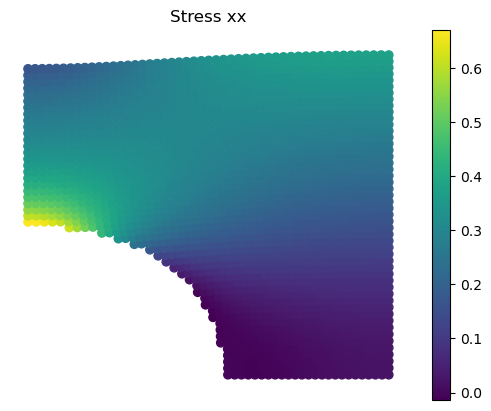

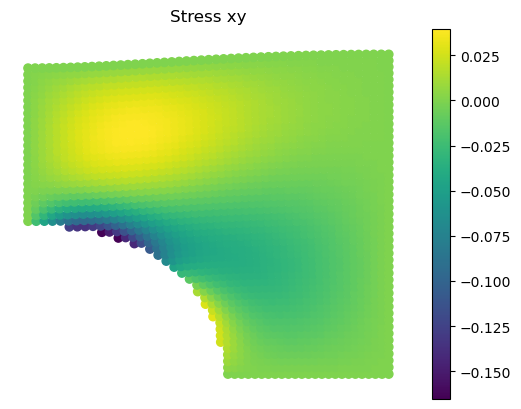

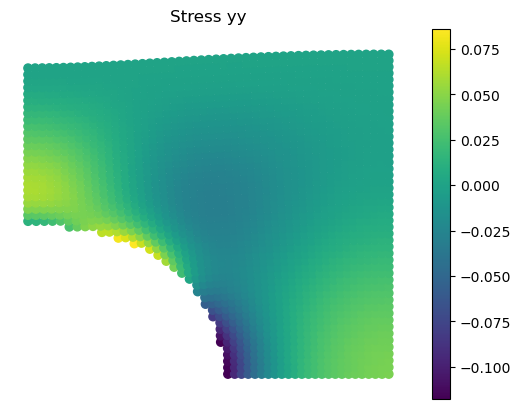

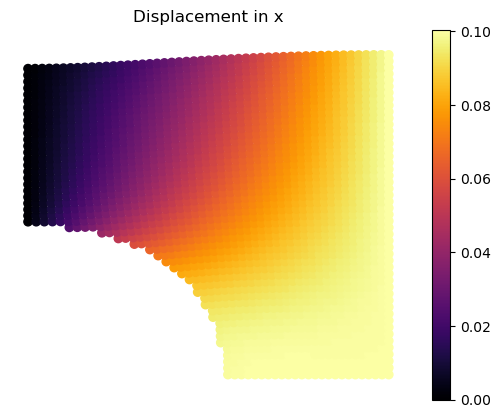

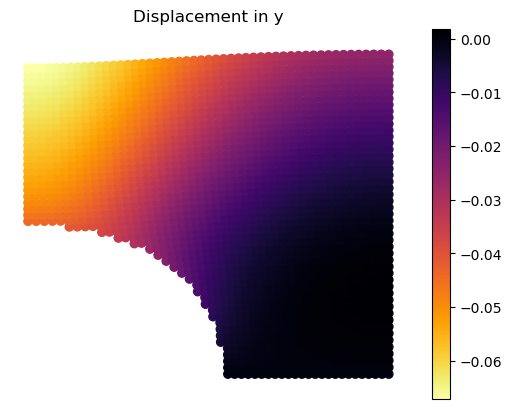

In [7]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (val_domain[:, 0] ** 2 + val_domain[:, 1] ** 2) > R**2
val_domain = val_domain[mask]
val = torch.tensor(val_domain, dtype=torch.float32, requires_grad=True)

# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
stress = torch.vmap(sigma)(val)


@torch.no_grad()
def make_plot(variable, title, **kwargs):
    plt.scatter(*def_val.T, c=variable, **kwargs)
    plt.axis("equal")
    plt.axis("off")
    plt.colorbar()
    plt.title(title)
    plt.show()


make_plot(stress[:, 0, 0], "Stress xx")
make_plot(stress[:, 0, 1], "Stress xy")
make_plot(stress[:, 1, 1], "Stress yy")
make_plot(disp[:, 0], "Displacement in x", cmap="inferno")
make_plot(disp[:, 1], "Displacement in y", cmap="inferno_r")